In [1]:
# Load in our libraries
import pandas as pd
import numpy as np
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

import seaborn as sns
sns.set_theme(style="whitegrid")  # 'darkgrid', 'ticks'

%matplotlib inline
import torch
import torchvision
from PIL import Image

/home/samarth/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
df = pd.read_pickle("WM811K.pkl")

In [3]:
df.info() #dataset check.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811457 entries, 0 to 811456
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   dieSize         811457 non-null  float64
 1   failureType     811457 non-null  object 
 2   lotName         811457 non-null  object 
 3   trainTestLabel  811457 non-null  object 
 4   waferIndex      811457 non-null  float64
 5   waferMap        811457 non-null  object 
dtypes: float64(2), object(4)
memory usage: 37.1+ MB


In [4]:
df.head()

,dieSize,failureType,lotName,trainTestLabel,waferIndex,waferMap
0,1683.0,none,lot1,Training,1.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,1683.0,none,lot1,Training,2.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,1683.0,none,lot1,Training,3.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,1683.0,none,lot1,Training,4.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,1683.0,none,lot1,Training,5.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [5]:
df.tail()

,dieSize,failureType,lotName,trainTestLabel,waferIndex,waferMap
811452,600.0,Edge-Ring,lot47542,Test,23.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,..."
811453,600.0,Edge-Loc,lot47542,Test,24.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1,..."
811454,600.0,Edge-Ring,lot47542,Test,25.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,..."
811455,600.0,"[0, 0]",lot47543,"[0, 0]",1.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,..."
811456,600.0,"[0, 0]",lot47543,"[0, 0]",2.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,..."


dataset has 47543 lot. Theoretically, there must be 25*47543 waferMap. but last Index is 811456.
Let's check this problem.

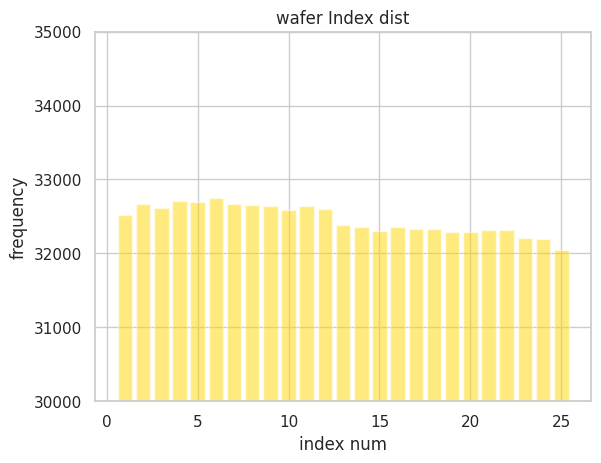

In [6]:
lot_index = np.unique(df.waferIndex, return_counts=True)
plt.bar(lot_index[0], lot_index[1], color='gold', align = 'center', alpha = 0.5)
plt.title("wafer Index dist")
plt.xlabel("index num")
plt.ylabel("frequency")
plt.ylim(30000, 35000)
plt.show()

each index frequency is not equal, but we're not use this column.
so drop waferIndex column.

In [7]:
df = df.drop(['waferIndex'], axis = 1)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811457 entries, 0 to 811456
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   dieSize         811457 non-null  float64
 1   failureType     811457 non-null  object 
 2   lotName         811457 non-null  object 
 3   trainTestLabel  811457 non-null  object 
 4   waferMap        811457 non-null  object 
dtypes: float64(1), object(4)
memory usage: 31.0+ MB


In [9]:
#add wafermapDim column because waferMap dim is different each other.
def find_dim(x):
    dim0=np.size(x,axis=0)
    dim1=np.size(x,axis=1)
    return dim0,dim1
df['waferMapDim']=df.waferMap.apply(find_dim)
df.sample(5)

,dieSize,failureType,lotName,trainTestLabel,waferMap,waferMapDim
737191,741.0,none,lot44527,Test,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1,...","(33, 29)"
653922,776.0,none,lot40910,Test,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","(30, 34)"
663399,712.0,"[0, 0]",lot41332,"[0, 0]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,...","(32, 29)"
217898,14116.0,"[0, 0]",lot13801,"[0, 0]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","(212, 84)"
468446,710.0,"[0, 0]",lot28796,"[0, 0]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1,...","(32, 29)"


In [10]:
# ensuring failureType contains plain strings
df['failureType'] = df['failureType'].astype(str).str.replace(r"[\[\]']", "", regex=True)

# mapping
mapping_type = {
    'Center': 0, 'Donut': 1, 'Edge-Loc': 2, 'Edge-Ring': 3,
    'Loc': 4, 'Random': 5, 'Scratch': 6, 'Near-full': 7, 'none': 8
}
df['failureNum'] = df['failureType'].map(mapping_type)

print(df['failureType'].value_counts())
print(df['failureNum'].value_counts())

failureType
0 0          638507
none         147431
Edge-Ring      9680
Edge-Loc       5189
Center         4294
Loc            3593
Scratch        1193
Random          866
Donut           555
Near-full       149
Name: count, dtype: int64
failureNum
8.0    147431
3.0      9680
2.0      5189
0.0      4294
4.0      3593
6.0      1193
5.0       866
1.0       555
7.0       149
Name: count, dtype: int64


In [11]:
#df_withlabel : labeled wafer
#df_withpattern : labeled & patterned wafer 
#df_nonpatter : labeled but non-patterned wafer
df_withlabel = df[(df['failureType']!=0)]
df_withlabel =df_withlabel.reset_index() #labeled index.
df_withpattern = df_withlabel[(df_withlabel['failureType'] != 'none')]
df_withpattern = df_withpattern.reset_index() #patterned index.
df_nonpattern = df_withlabel[(df_withlabel['failureType'] == 'none')] #nonpatterned index
df_withlabel.shape[0], df_withpattern.shape[0], df_nonpattern.shape[0]

(811457, 664026, 147431)

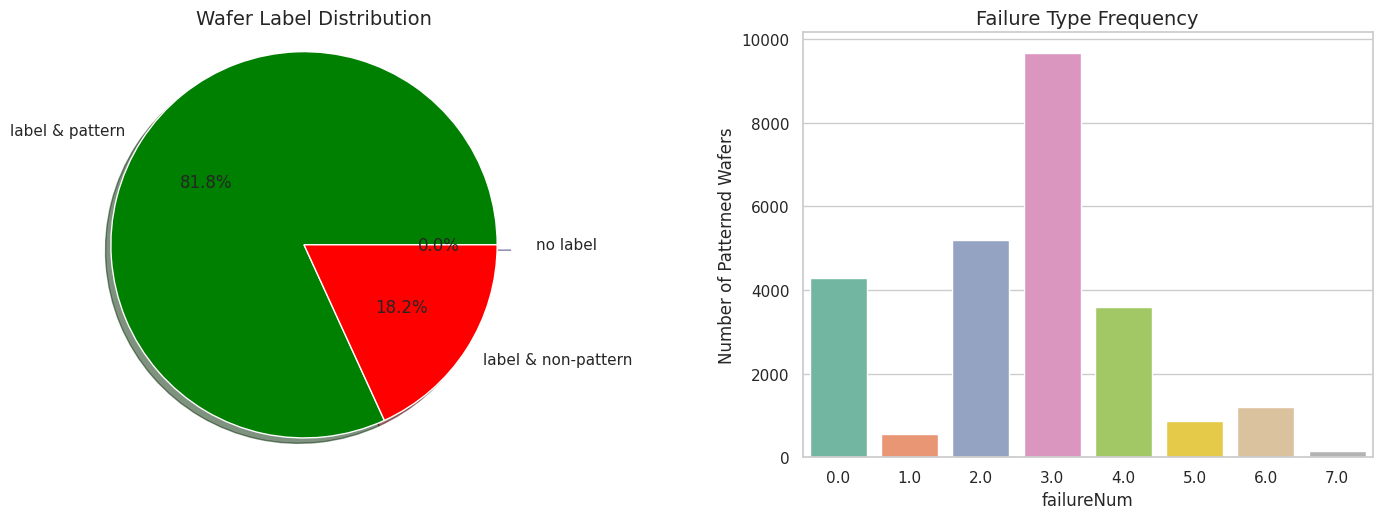

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
colors = ['blue', 'green', 'red']
num_wafers = [
    len(df['waferMap']) - df_withlabel.shape[0],  # wafers with no label
    df_withpattern.shape[0],                      # wafers with label & pattern
    df_nonpattern.shape[0]                        # wafers with label & non-pattern
]
labels = ['no label', 'label & pattern', 'label & non-pattern']

# Pie chart for wafer label distribution
ax[0].pie(
    num_wafers,
    explode=(0.1, 0, 0),      # highlight the first slice
    labels=labels,
    colors=colors,
    autopct='%1.1f%%',        # percentage formatting
    shadow=True
)
ax[0].set_title("Wafer Label Distribution", fontsize=14)
ax[0].axis("equal")           # ensure circular shape

# Countplot for failure type frequency (fix palette deprecation warning)
sns.countplot(
    x='failureNum',
    hue='failureNum',          # use x as hue
    data=df_withpattern,
    ax=ax[1],
    palette="Set2",
    legend=False               # hide redundant legend
)
ax[1].set_title("Failure Type Frequency", fontsize=14)
ax[1].set_ylabel("Number of Patterned Wafers")

plt.tight_layout(pad=3.0)
plt.show()


In [13]:
df_withlabel['waferMapDim'].value_counts() #use two dim (25,27) & (26,26)

waferMapDim
(32, 29)    108687
(25, 27)     64083
(49, 39)     39323
(26, 26)     30078
(30, 34)     29513
             ...  
(53, 70)         1
(99, 69)         1
(38, 50)         1
(45, 47)         1
(27, 71)         1
Name: count, Length: 632, dtype: int64

In [14]:
#extract (25,27) & (26,26) waferMapDim data
def subwafer(sw,label):
  Dim0 = np.size(sw, axis=1)
  Dim1 = np.size(sw, axis=2)
  sub_df = df_withlabel.loc[df_withlabel['waferMapDim'] == (Dim0, Dim1)]
  sub_wafer = sub_df['waferMap'].values
  sw = sw.to(torch.device('cuda'))
  for i in range(len(sub_df)):
    waferMap = torch.from_numpy(sub_df.iloc[i,:]['waferMap'].reshape(1, Dim0, Dim1))
    waferMap = waferMap.to(torch.device('cuda'))
    sw = torch.cat([sw, waferMap])
    label.append(sub_df.iloc[i,:]['failureType'][0][0])
  x = sw[1:]
  y = np.array(label).reshape((-1,1))
  del waferMap, sw
  return x, y

In [15]:
sw0 = torch.ones((1, 25, 27))
sw1 = torch.ones((1, 26, 26))
label0 = list()
label1 = list()

In [16]:
x0, y0 = subwafer(sw0, label0) #about 13s
x1, y1 = subwafer(sw1, label1) #about 13s

In [17]:
x0.shape, x1.shape

(torch.Size([64083, 25, 27]), torch.Size([30078, 26, 26]))

In [18]:
#add RGB space for one-hot encoding
# 0: non wafer -> R, 1: normal die -> G, 2: defect die -> B|

def rgb_sw(x):
  Dim0 = np.size(x, axis=1)
  Dim1 = np.size(x, axis=2)
  new_x = np.zeros((len(x), Dim0, Dim1, 3))
  x = torch.unsqueeze(x,-1)
  x = x.to(torch.device('cpu'))
  x = x.numpy()
  for w in range(len(x)): 
      for i in range(Dim0):
          for j in range(Dim1):
              new_x[w, i, j, int(x[w, i, j])] = 1
  return new_x

In [19]:
rgb_x0 = rgb_sw(x0) #about 8s each line.
rgb_x1 = rgb_sw(x1)

/tmp/ipykernel_5951/1484845009.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_x[w, i, j, int(x[w, i, j])] = 1


In [20]:
del x0, x1 #delete useless data

In [21]:
#To use two dim, we have to resize these data.
def resize(x):
  rwm = torch.ones((1,56,56,3))
  for i in range(len(x)):
    rwm = rwm.to(torch.device('cuda'))
    a = Image.fromarray(x[i].astype('uint8')).resize((56,56))
    a = np.array(a).reshape((1,56,56,3))
    a = torch.from_numpy(a)
    a = a.to(torch.device('cuda'))
    rwm = torch.cat([rwm, a])
  x = rwm[1:]
  del rwm
  return x

In [22]:
resized_x0 = resize(rgb_x0)
resized_x1 = resize(rgb_x1)

KeyboardInterrupt: 

In [ ]:
plt.imshow(rgb_x0[1000])
plt.show()
plt.imshow(torch.argmax(resized_x0[1000],axis=2).cpu().numpy())
plt.show()
# reszied_wafer is added some noise. but I think for classification pattern, some noise is not important.

In [ ]:
del rgb_x0, rgb_x1 #delete useless data

In [ ]:
resized_wm = torch.cat([resized_x0, resized_x1])
label_wm = np.concatenate((y0,y1)) #concatenate To use all data.

In [ ]:
del y0,y1,resized_x0, resized_x1

In [ ]:
#Convolutional Autoencoder
# parameter
args = {
	'BATCH_SIZE': 16,
        'LEARNING_RATE': 0.001,
        'NUM_EPOCH': 10
        }

In [ ]:
resized_wm = resized_wm.permute(0,3,1,2)

In [ ]:
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
train_loader  = torch.utils.data.DataLoader(resized_wm, args['BATCH_SIZE'], shuffle=True)

In [ ]:
resized_wm.shape, label_wm.shape

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init
from torch.utils.data import Dataset, DataLoader,TensorDataset,random_split,SubsetRandomSampler, ConcatDataset

In [ ]:
class ConvAutoEncoder(nn.Module):
    def __init__(self):
        super(ConvAutoEncoder, self).__init__()
        
        # Encoder
        self.cnn_layer1 = nn.Sequential(
                        nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
                        nn.ReLU(),
                         nn.MaxPool2d(2,2))

        self.cnn_layer2 = nn.Sequential(
                                nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
                                nn.ReLU(),
                                 nn.MaxPool2d(2,2))

        # Decoder
        self.tran_cnn_layer1 = nn.Sequential(
                        nn.ConvTranspose2d(32, 16, kernel_size = 2, stride = 2, padding=0),
                        nn.ReLU())

        self.tran_cnn_layer2 = nn.Sequential(
                        nn.ConvTranspose2d(16, 3, kernel_size = 2, stride = 2, padding=0),
                        nn.Sigmoid())
            
    def encoder(self, x):
        encode = self.cnn_layer1(x)
        encode = self.cnn_layer2(encode)   
        return encode
    
    def decoder(self, x):
        decode = self.tran_cnn_layer1(x)
        decode = self.tran_cnn_layer2(decode)
        return decode

    def forward(self, x):
        output = self.encoder(x)
        output = self.decoder(output)
        return output

In [ ]:
model = ConvAutoEncoder().to(DEVICE)
print(model)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=args['LEARNING_RATE'])

In [ ]:
!pip install ../input/torchsummary/torchsummary-1.5.1-py3-none-any.whl

In [ ]:
from torchsummary import summary
summary(model,(3,54,54), batch_size=16)

In [ ]:
steps = 0
print(resized_wm.shape)
total_steps = len(train_loader)
losses =[]
iterations = []
for epoch in range(args['NUM_EPOCH']):    
    running_loss = 0.0
    for i,wafer in enumerate(train_loader):
        steps += 1
        wafer = wafer.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(wafer)
        loss = criterion(outputs, wafer) #autoencoder loss : compare input & output
        loss.backward()
        running_loss += loss.item()*wafer.shape[0]
        optimizer.step()
        if steps % total_steps == 0:
            model.eval()
            print('Epoch: {}/{}'.format(epoch+1, args['NUM_EPOCH']),
                 "=> loss : %.3f"%(running_loss/total_steps))
            steps = 0
            iterations.append(i)
            losses.append(running_loss / total_steps)
            model.train()

In [ ]:
del wafer, optimizer, loss

In [ ]:
faulty_case = np.unique(label_wm)
print(faulty_case)

In [ ]:
import torch.nn.init
# augment function define
def gen_data(wafer, label):
  gen_x = torch.zeros((1, 3, 56, 56))
  with torch.no_grad():
    encoded_x = model.encoder(wafer).to(torch.device('cpu'))
    # dummy array for collecting noised wafer 
    # Make wafer until total # of wafer to 2000
    for i in range((2000//len(wafer)) + 1):
      noised_encoded_x = (encoded_x + torch.from_numpy(np.random.normal(loc=0, scale=0.1, size = (len(encoded_x), 32, 14, 14))).to(torch.device('cpu'))).to(DEVICE)
      noised_decoded_x = model.decoder(noised_encoded_x.float()).to(torch.device('cpu'))
      gen_x = torch.cat([gen_x, noised_decoded_x], axis=0)
    # also make label vector with same length
    gen_y = np.full((len(gen_x), 1), label)
    # return date without 1st dummy data.
  del encoded_x, noised_encoded_x, noised_decoded_x
  return gen_x[1:], gen_y[1:]

In [ ]:
# Augmentation for all faulty case.
for f in faulty_case : 
    # skip none case
    if f == 'none' : 
        continue
    gen_x, gen_y = gen_data(resized_wm[np.where(label_wm==f)[0]].to(DEVICE), f)
    resized_wm = torch.cat([resized_wm.to(torch.device('cpu')), gen_x], axis=0)
    label_wm = np.concatenate((label_wm, gen_y))

In [ ]:
print('After Generate resized_wm shape : {}, label_wm shape : {}'.format(resized_wm.shape, label_wm.shape))
del gen_x, gen_y

In [ ]:
none_idx = np.where(label_wm=='none')[0][np.random.choice(len(np.where(label_wm=='none')[0]), size=27150, replace=False)]
EdgeLoc_idx = np.where(label_wm=='Edge-Loc')[0][np.random.choice(len(np.where(label_wm=='Edge-Loc')[0]), size=1100, replace=False)]
Center_idx = np.where(label_wm=='Center')[0][np.random.choice(len(np.where(label_wm=='Center')[0]), size=2500, replace=False)]
Loc_idx = np.where(label_wm=='Loc')[0][np.random.choice(len(np.where(label_wm=='Loc')[0]), size=600, replace=False)]

In [ ]:
delete_idx = np.concatenate((none_idx, EdgeLoc_idx, Center_idx, Loc_idx))
delete_idx.shape

In [ ]:
resized_wm.shape

In [ ]:
remove_wm = np.delete(resized_wm.detach().cpu().numpy(), delete_idx, axis=0)
resized_wm = torch.from_numpy(remove_wm)

In [ ]:
del_idx = np.concatenate((none_idx, EdgeLoc_idx, Center_idx, Loc_idx))
label_wm = np.delete(label_wm, del_idx, axis=0)

In [ ]:
n, bins, patches = plt.hist(label_wm, bins=9)
plt.xticks(rotation=90)
plt.show()

In [ ]:
# one-hot-encoding
for i, l in enumerate(faulty_case):
    label_wm[label_wm==l] = i    
    print('i : {}, l : {}'.format(i, l))
def _to_one_hot(y, num_classes):
    scatter_dim = len(y.size())
    y_tensor = y.view(*y.size(), -1)
    zeros = torch.zeros(*y.size(), num_classes, dtype=y.dtype)
    return zeros.scatter(scatter_dim, y_tensor, 1)

label_wm = _to_one_hot(torch.as_tensor(np.int64(label_wm)), num_classes=9)

In [ ]:
import torch.utils.data as data
class BasicDataset(data.Dataset):
    def __init__(self, x_tensor, y_tensor):
        super(BasicDataset, self).__init__()

        self.x = x_tensor
        self.y = y_tensor
        
    def __getitem__(self, index):
        return self.x[index], self.y[index]

    def __len__(self):
        return len(self.x)

In [ ]:
from sklearn import model_selection

In [ ]:
train_X, test_X, train_Y, test_Y = model_selection.train_test_split(resized_wm, label_wm , test_size=0.2)
dataset_train = BasicDataset(train_X,train_Y)
dataset_test = BasicDataset(test_X, test_Y)
dataset = ConcatDataset([dataset_train, dataset_test])

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.keep_prob1 = 0.2
        self.keep_prob2 = 0.5

        self.layer1 =nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1), #1번째 conv layer : 입력 층 3, 출력 32, Relu, Poolling으로 MAX 직용.
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

    
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1), #2번째 conv layer : 입력 층 32, 출력 64, Relu, Poolling으로 MAX 직용.
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        

        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1), #3번째 conv layer : 입력 층 64, 출력 128, Relu, Polling으로 Max 적용.
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1))

        self.fc1 = nn.Linear(8 * 8 * 128, 1250, bias=True) # fully connected, 
        nn.init.xavier_uniform_(self.fc1.weight)
        self.layer4 = nn.Sequential(
            self.fc1,
            nn.ReLU()) #dropout 적용

        self.fc2 = nn.Linear(1250, 9, bias=True) #오류패턴 9개로 출력 9
        nn.init.xavier_uniform_(self.fc2.weight)
        

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)   # fully conntect를위해 flatten을 함.
        out = self.layer4(out)
        out = self.fc2(out)
        return out

In [ ]:
CNN = CNN().to(DEVICE)
print(CNN)
summary(CNN,(3,56,56), batch_size=16)

In [ ]:
args = {
	'BATCH_SIZE': 256,
        'LEARNING_RATE': 0.005,
        'NUM_EPOCH': 10
        }

In [ ]:

criterion = torch.nn.CrossEntropyLoss().to(DEVICE) # 비용 함수에 소프트맥스 함수 포함되어져 있음.
optimizer = torch.optim.Adam(CNN.parameters(), lr=args['LEARNING_RATE'])
torch.manual_seed(42)
splits = KFold(n_splits=5, shuffle = True, random_state = 42)
foldperf={}

In [ ]:
def train_epoch(model, dataloader,loss_fn,optimizer):
    train_loss,train_correct=0.0,0
    model.train()
    for images, labels in dataloader:
        images,labels = images.to(DEVICE),labels.to(DEVICE).reshape(args['BATCH_SIZE'], 9)
        optimizer.zero_grad()
        output = model(images)
        labels = torch.argmax(labels, dim=1)
        loss = loss_fn(output,labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
        predictions = torch.argmax(output, 1)
        train_correct += (predictions == labels).sum().item()
    print(train_correct)
    return train_loss,train_correct
  
def valid_epoch(model,dataloader,loss_fn):
    valid_loss, val_correct = 0.0, 0
    model.eval()
    for images, labels in dataloader:
        images,labels = images.to(DEVICE),labels.to(DEVICE).reshape(args['BATCH_SIZE'],9)
        output = model(images)
        labels = torch.argmax(labels, dim=1)
        loss=loss_fn(output,labels)
        valid_loss+=loss.item() * images.size(0)
        predictions = torch.argmax(output, 1)
        val_correct+=(predictions == labels).sum().item()
    return valid_loss,val_correct

In [ ]:
for fold, (train_idx,val_idx) in enumerate(splits.split(np.arange(len(dataset)))):
    print('Fold {}'.format(fold + 1))

    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(val_idx)
    train_loader = DataLoader(dataset, batch_size=args['BATCH_SIZE'], sampler=train_sampler, drop_last=True)
    test_loader = DataLoader(dataset, batch_size=args['BATCH_SIZE'], sampler=test_sampler, drop_last=True)
    history = {'train_loss': [], 'test_loss': [],'train_acc':[],'test_acc':[]}

    for epoch in range(args['NUM_EPOCH']):
        train_loss, train_correct=train_epoch(CNN,train_loader,criterion,optimizer)
        test_loss, test_correct=valid_epoch(CNN,test_loader,criterion)
        train_loss = train_loss / len(train_loader.sampler)
        train_acc = train_correct / len(train_loader.sampler) * 100
        test_loss = test_loss / len(test_loader.sampler)
        test_acc = test_correct / len(test_loader.sampler) * 100

        print("Epoch:{}/{} AVG Training Loss:{:.3f} AVG Test Loss:{:.3f} AVG Training Acc {:.2f} % AVG Test Acc {:.2f} %".format(epoch + 1,
                                                                                                             args['NUM_EPOCH'],
                                                                                                             train_loss,
                                                                                                             test_loss,
                                                                                                             train_acc,
                                                                                                             test_acc))
        history['train_loss'].append(train_loss)
        history['test_loss'].append(test_loss)
        history['train_acc'].append(train_acc)
        history['test_acc'].append(test_acc)

    foldperf['fold{}'.format(fold+1)] = history  

torch.save(model,'k_cross_CNN.pt')    

In [ ]:
testl_f,tl_f,testa_f,ta_f=[],[],[],[]
k=5
for f in range(1,k+1):

     tl_f.append(np.mean(foldperf['fold{}'.format(f)]['train_loss']))
     testl_f.append(np.mean(foldperf['fold{}'.format(f)]['test_loss']))

     ta_f.append(np.mean(foldperf['fold{}'.format(f)]['train_acc']))
     testa_f.append(np.mean(foldperf['fold{}'.format(f)]['test_acc']))

print('Performance of {} fold cross validation'.format(k))
print("Average Training Loss: {:.3f} \t Average Test Loss: {:.3f} \t Average Training Acc: {:.2f} \t Average Test Acc: {:.2f}".format(np.mean(tl_f),np.mean(testl_f),np.mean(ta_f),np.mean(testa_f)))     

In [ ]:
tl_f

In [ ]:
# accuracy plot 
plt.plot(ta_f)
plt.plot(testa_f)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# loss plot
plt.plot(tl_f)
plt.plot(testl_f)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()